In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from skimage.feature import local_binary_pattern
from skimage.filters import median
from tensorflow.keras import datasets, layers, models

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import os
import csv
import time
import numpy as np
import json
import cv2
from PIL import Image
import os
import PIL
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [2]:
dataset, dataset_info = tfds.load('oxford_flowers102', data_dir='/root/tensorflow_datasets/', as_supervised=True, with_info=True, download=True)
training_set, validation_set, testing_set = dataset['train'], dataset['validation'], dataset['test']

In [3]:
# Create a testing set for internal testing
SIZE = 256
test_image_set = []
test_label_set = []
for image, label in training_set.take(20):
    image = image.numpy().squeeze()
    resized_image = cv2.resize(image, (SIZE, SIZE))
    test_image_set.append(resized_image)

    label = label.numpy()
    test_label_set.append(label)

In [4]:
# Functions for image processing
def show_image(img):
    plt.axis('off')
    plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    plt.show()
    
def blur_image(img):
  blurred = cv2.fastNlMeansDenoisingColored(img, None, 11, 6, 7, 21)
  gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
  #blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  return gray

def img_threshold(img):
  dst = cv2.fastNlMeansDenoisingColored(img, None, 11, 6, 7, 21)
  dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
  dst = dst.astype("uint8")
  dst = median(dst, np.ones((3,3)))
  ret, thresh1 = cv2.threshold(dst, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return thresh1

def grey_and_blur(img):
  grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  blurred = cv2.GaussianBlur(grey, (5,5), 0)
  return blurred

def greyscale(img):
  grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return grey

def fix_small_holes(img, original_img):
  grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  contours, _ = cv2.findContours(grey.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  area_threshold = 200
  large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > area_threshold]
  cleaned = np.zeros(grey.shape, dtype=np.uint8)
  cv2.drawContours(cleaned,  large_contours, -1, 255, thickness=cv2.FILLED)
  masked = cv2.bitwise_and(original_img, original_img, mask=cleaned)
  return masked

def remove_small_objects(img, original_img):
  grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # find all of the connected components
  nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(grey)
  # we're interested only in the size of the blobs, contained in the last column of stats.
  sizes = stats[:, -1]
  # take the background out of the size array as we dont want to operate on that
  sizes = sizes[1:]
  nb_blobs -= 1

  # minimum size of particles we want to keep (number of pixels).
  min_size = 500  
  im_result = np.zeros_like(im_with_separated_blobs)
  for blob in range(nb_blobs):
      if sizes[blob] >= min_size:
          im_result[im_with_separated_blobs == blob + 1] = 255

  masked = cv2.bitwise_and(original_img, original_img, mask=im_result.astype(np.uint8))
  return masked

def generate_region_of_interest(img):
  grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  cnts = cv2.findContours(grey, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]

  largest = 0
  for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    totalSize = w*h
    if totalSize > largest:
      ROI = img[y:y+h, x:x+w]
      largest = totalSize
  return ROI

In [5]:
def threshold(img, blur = True):
  to_thresh = img
  if blur:
    to_thresh = grey_and_blur(img)
  else:
    to_thresh = greyscale(img)
  # blurred = grey_and_blur(img)
  #show_image(blurred)
  thresh = cv2.adaptiveThreshold(to_thresh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 10)
  masked = cv2.bitwise_and(img, img, mask=thresh)
  if blur:
    to_thresh = grey_and_blur(img)
  else:
    to_thresh = greyscale(img)
  #show_image(blurred)
  (T, threshInv) = cv2.threshold(to_thresh, 0, 120, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  masked = cv2.bitwise_and(img, img, mask=threshInv)
  return masked

def mask_green(img):
  # set number of colors
  hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  #cv2_imshow(img)
  # Green color
  low_green = np.array([25, 52, 72])
  high_green = np.array([102, 255, 255])
  green_mask = cv2.inRange(hsv_img, low_green, high_green)
  green_mask = 255 - green_mask
  green = cv2.bitwise_and(img, img, mask=green_mask)
  #cv2_imshow(green)
  return green

def normal_processing(img):
  thre = threshold(img, False)
  removed = remove_small_objects(thre, img)
  fixed = fix_small_holes(removed, img)
  ROI = generate_region_of_interest(fixed)
  return ROI

def blurred_processing(img):
  thre = threshold(img)
  removed = remove_small_objects(thre, img)
  fixed = fix_small_holes(removed, img)
  ROI = generate_region_of_interest(fixed)
  return ROI

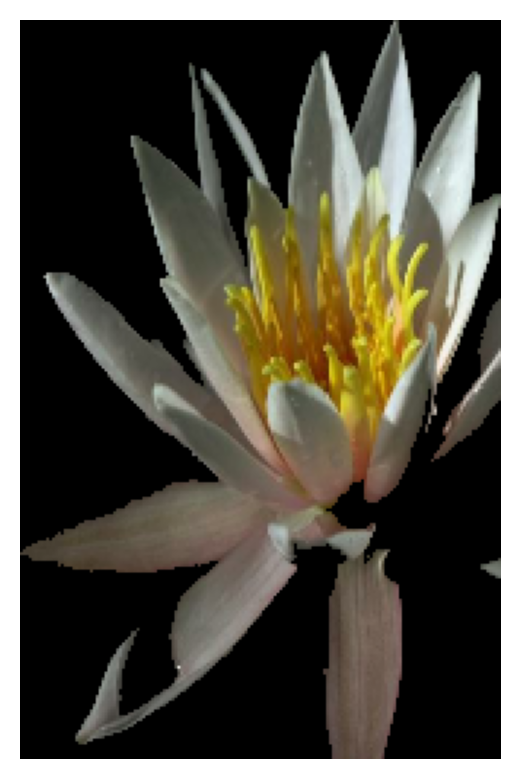

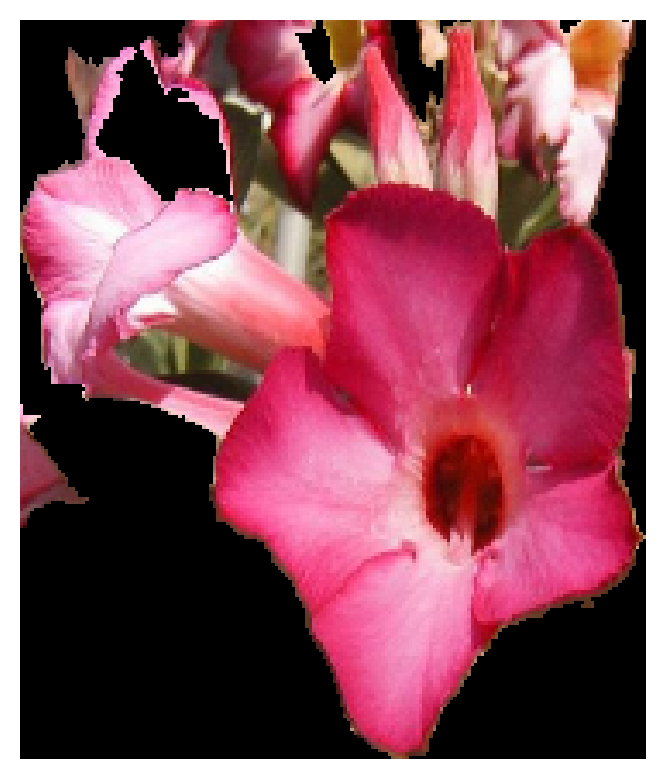

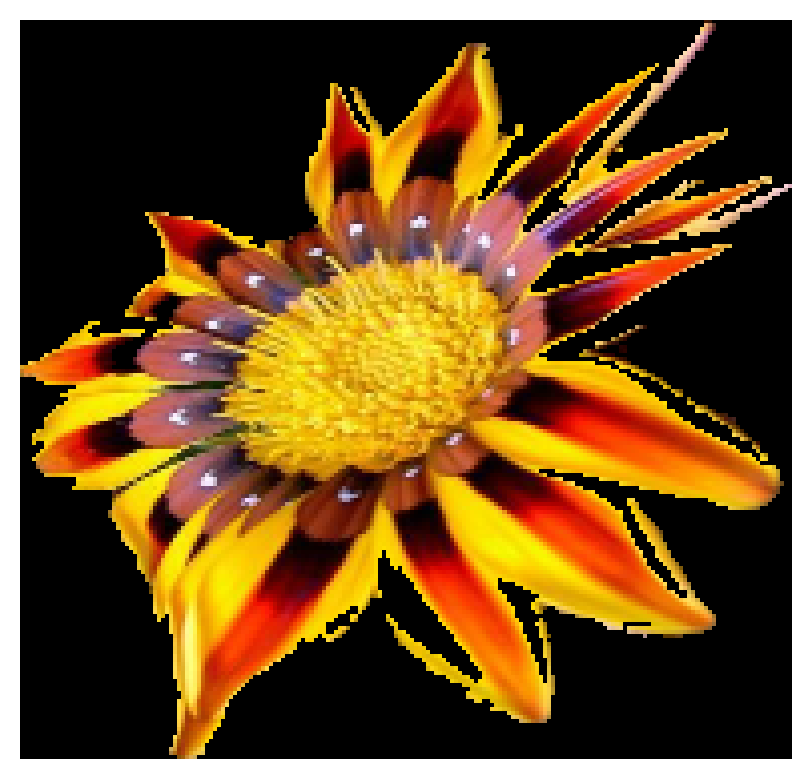

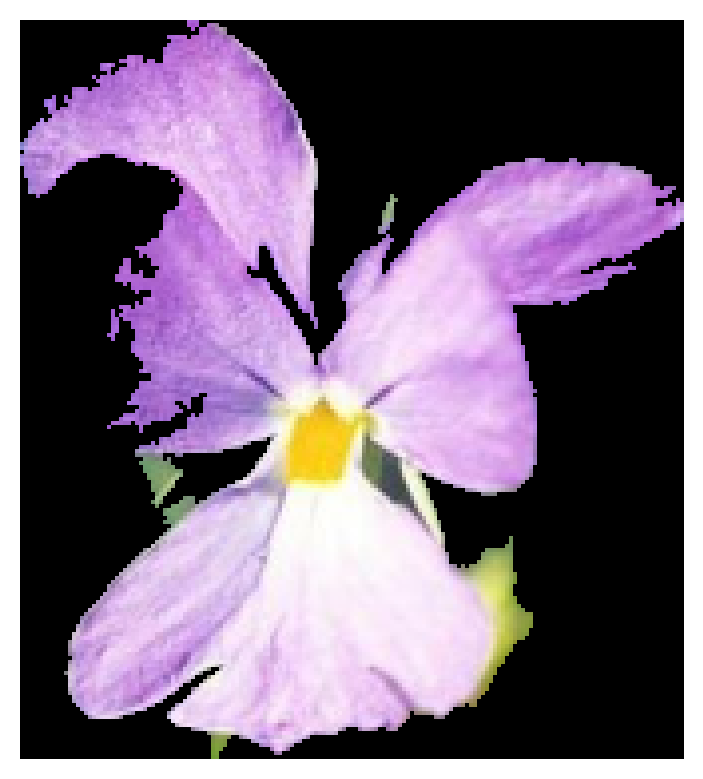

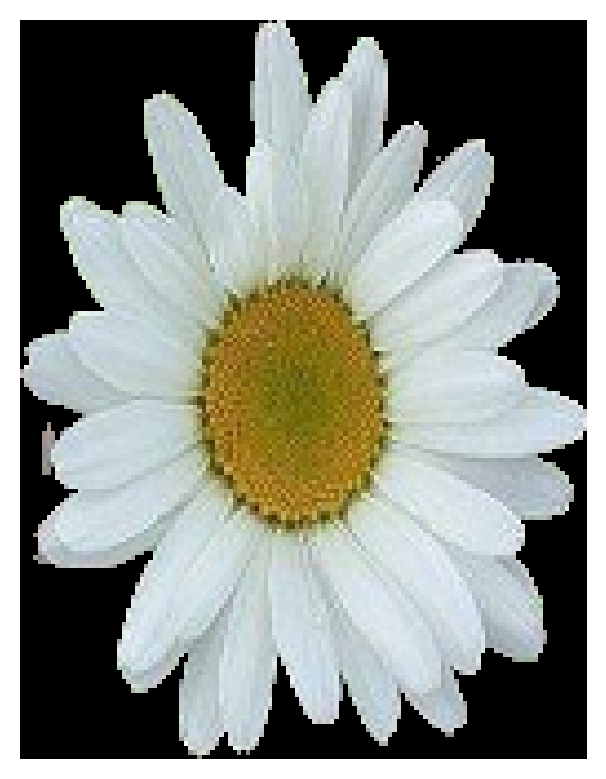

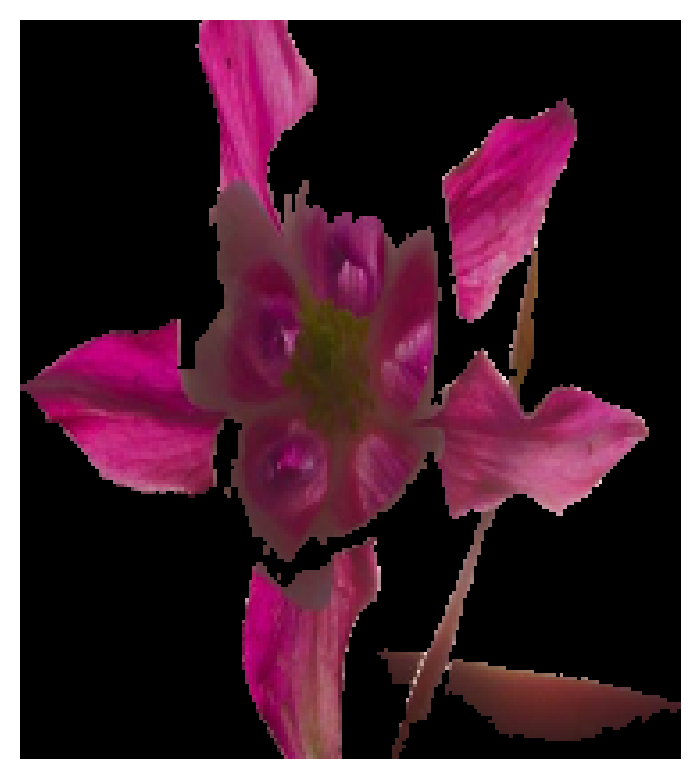

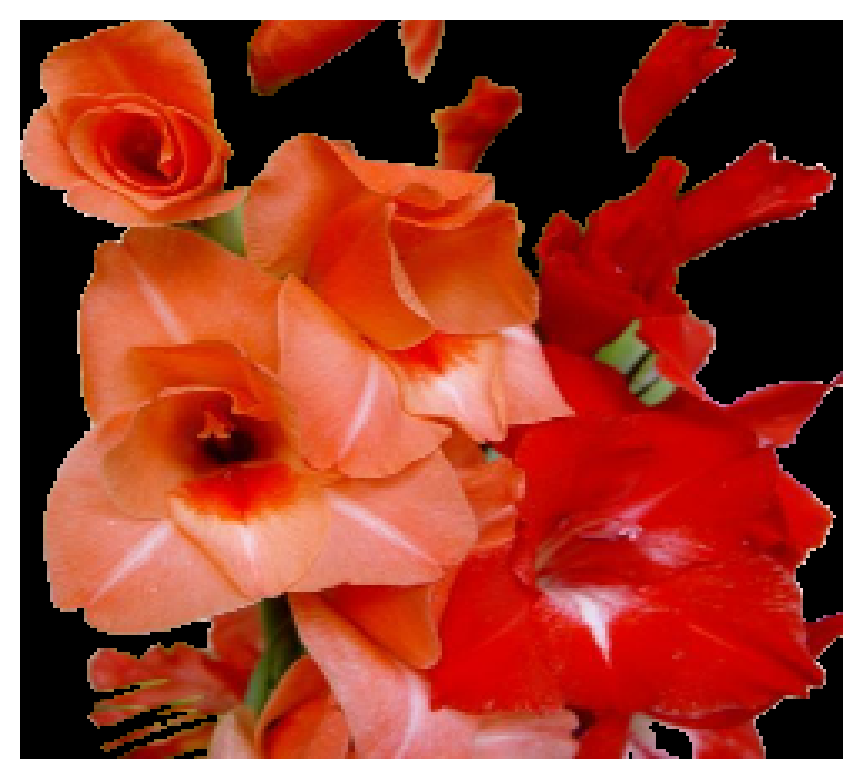

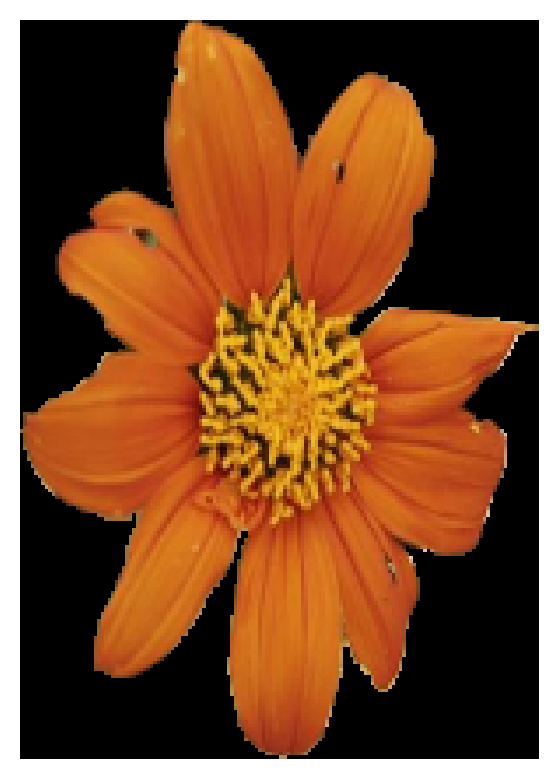

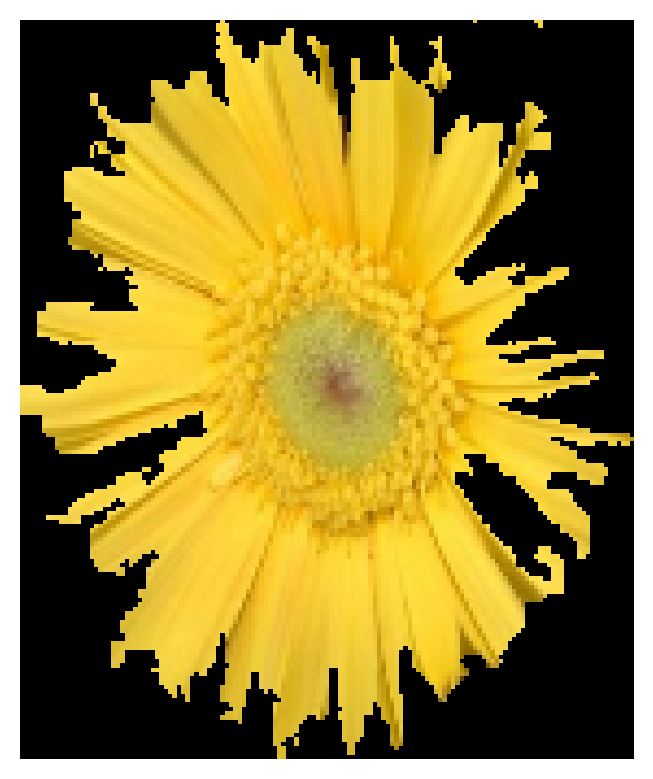

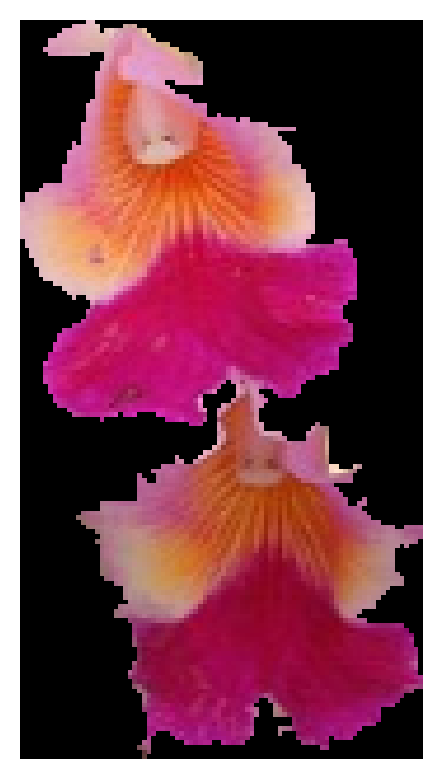

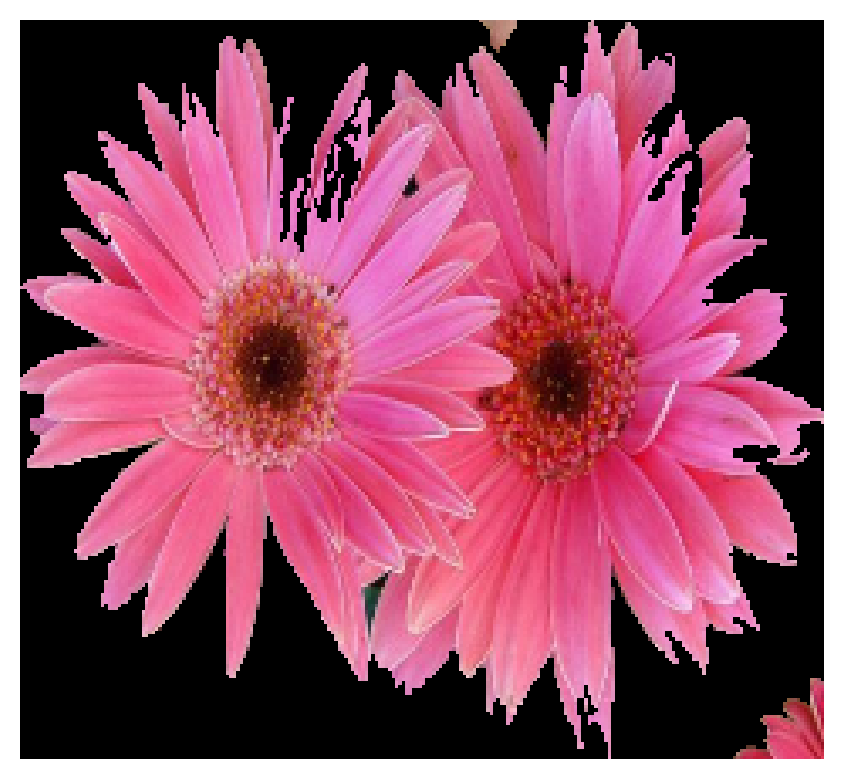

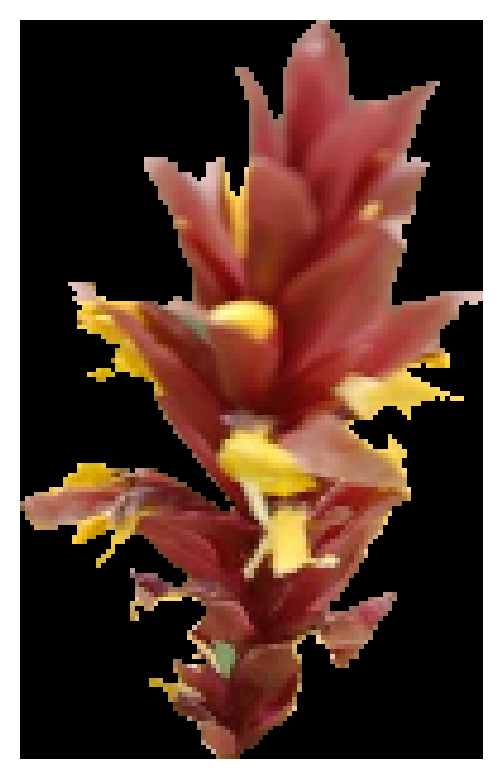

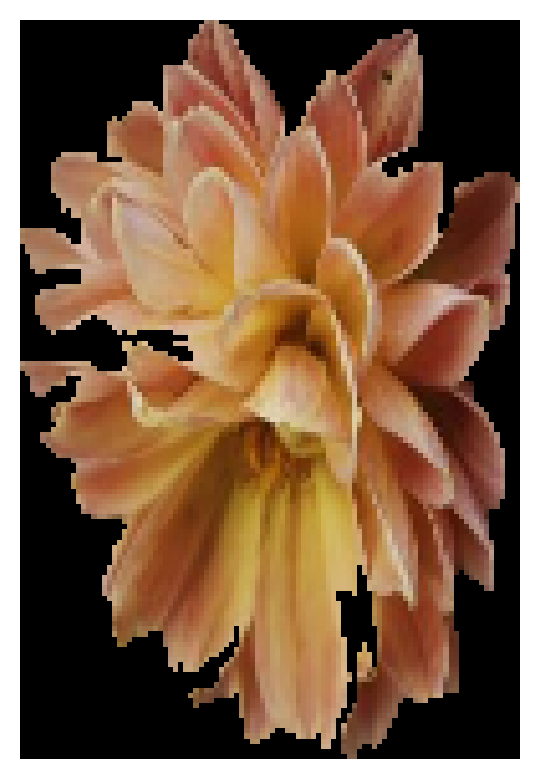

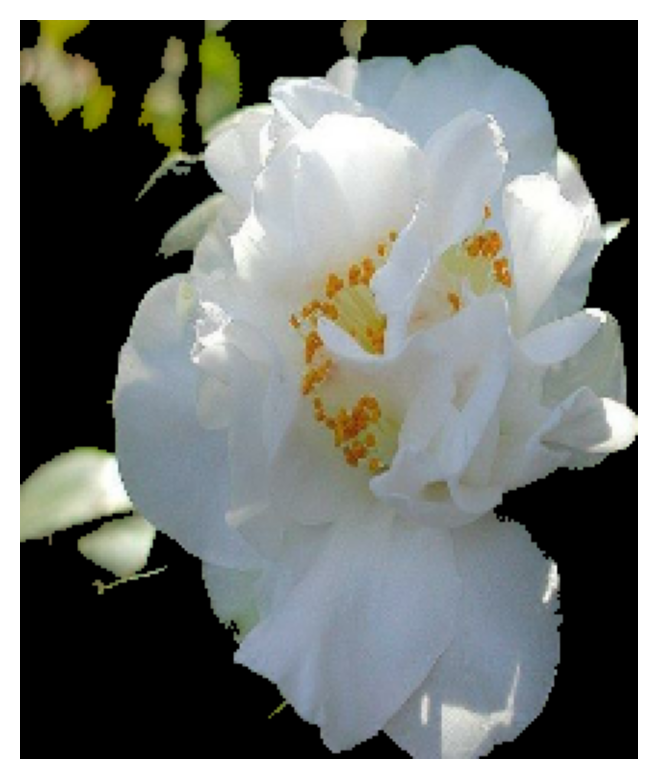

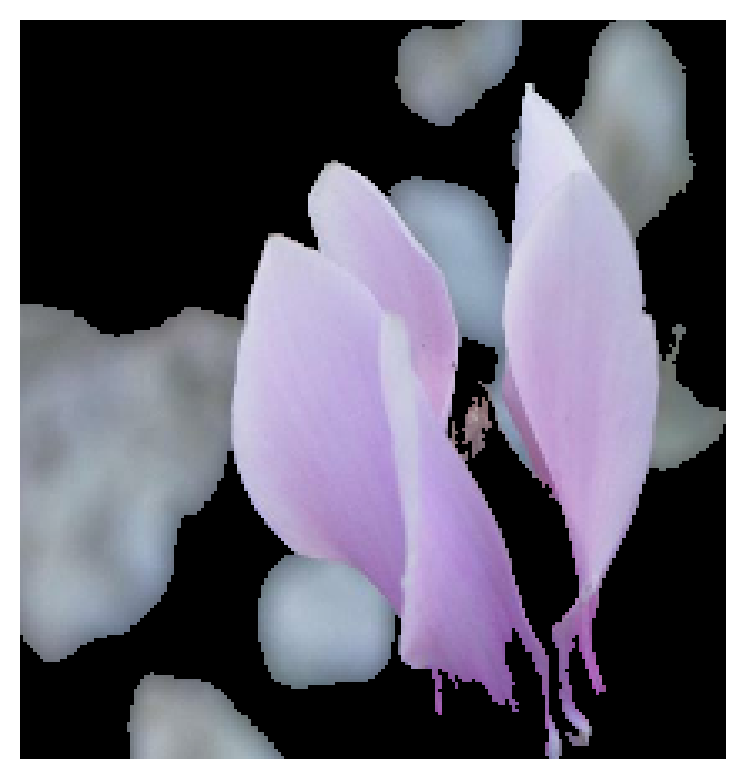

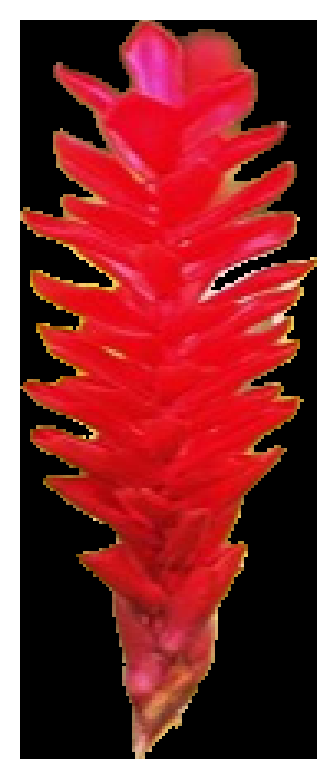

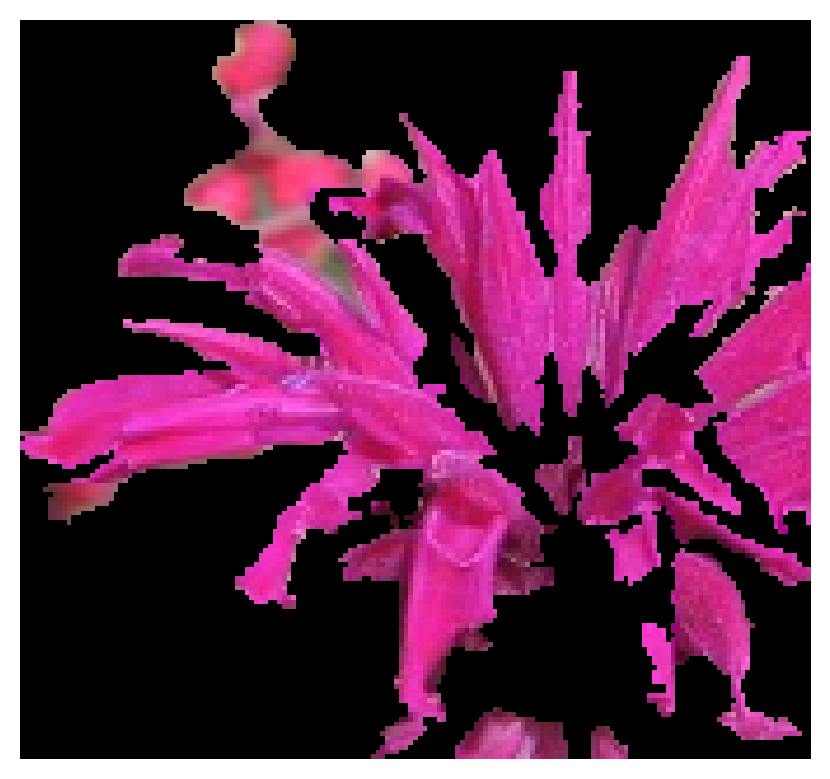

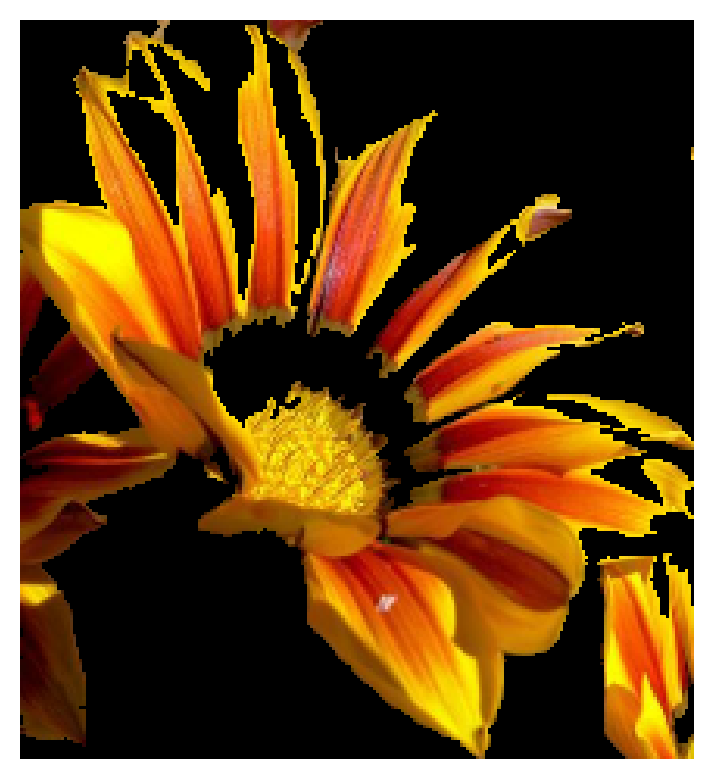

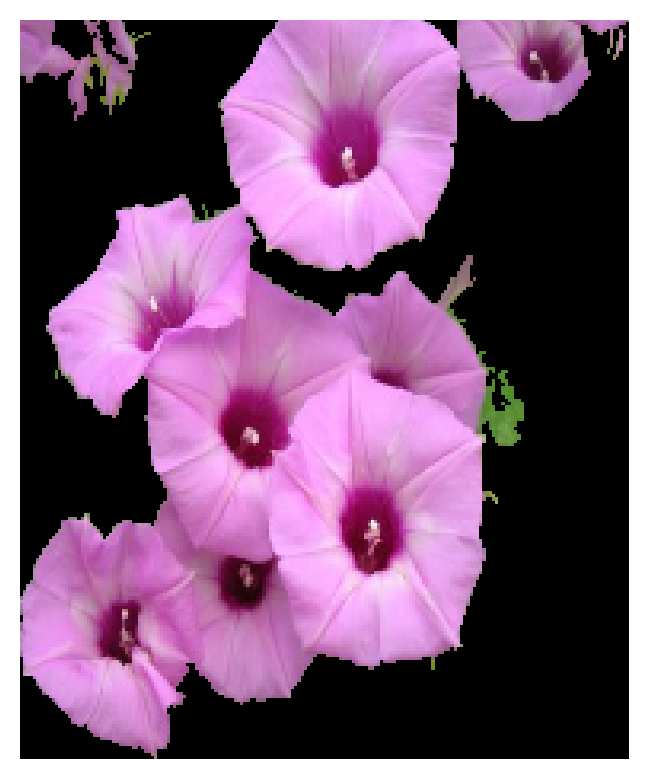

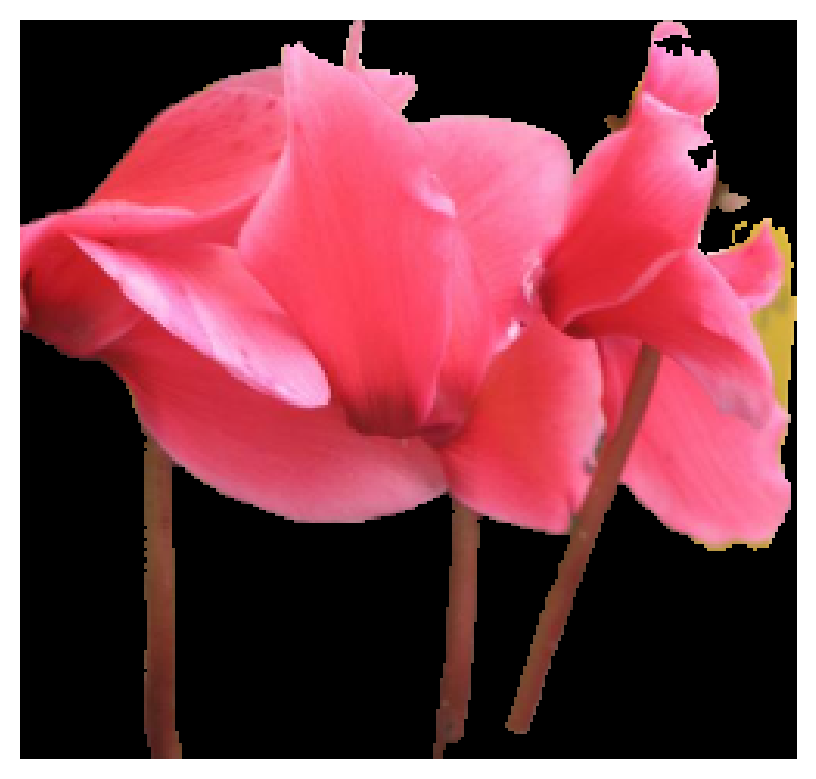

In [19]:
def remove_green_pixels(img):
    no_green_pixels = img.copy()
    # Define the threshold range for green pixels
    GREEN_THRESHOLD = 30
    
    # Loop over each pixel in the image
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Get the pixel value (R, G, B)
            pixel = img[i, j]
            g = pixel[0]
            r = pixel[1]
            b = pixel[2]

            # Check if the pixel is green (within the threshold range)
            if g > r + GREEN_THRESHOLD and g > b + GREEN_THRESHOLD:
                continue  # Skip green pixels
            
            # Increase the contrast of the non-green pixel
            contrast = 1.5
            # new_pixel = tuple(np.clip(np.array((pixel - 128) * contrast + 128), 0, 255).astype(np.uint8))
            
            # Set the new pixel value
            no_green_pixels[i, j] = 0    
    return no_green_pixels

def black_pixels_percent(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Create a mask of black pixels
    mask = gray == 0

    # Count the number of black pixels
    num_black_pixels = np.count_nonzero(mask)

    # Calculate the percentage of black pixels
    percent_black_pixels = (num_black_pixels / np.size(gray)) * 100

    # Return the percentage of black pixels
    return percent_black_pixels

def remove_zeros(arr):
    # Use list comprehension to filter out all zeros
    arr = [elem for elem in arr if elem != 0]
    return arr


for img in test_image_set:
    removed = remove_green_pixels(img)
    processed = fix_small_holes(removed, img)
    if black_pixels_percent(processed) > 95:
        processed = normal_processing(img)
    else:
        processed = generate_region_of_interest(processed)
    show_image(processed)
#print(get_petal_count(processed))

In [13]:
# Functions for feature extraction

def get_hsv_lab_scaled(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = img_hsv[:,:,0], img_hsv[:,:,1], img_hsv[:,:,2]
    h_scaled = (h - np.min(h)) / (np.max(h) - np.min(h))
    s_scaled = (s - np.min(s)) / (np.max(s) - np.min(s))
    v_scaled = (v - np.min(v)) / (np.max(v) - np.min(v))

    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = img_lab[:,:,0], img_lab[:,:,1], img_lab[:,:,2]
    l_scaled = (l - np.min(l)) / (np.max(l) - np.min(l))
    a_scaled = (a - np.min(a)) / (np.max(a) - np.min(a))
    b_scaled = (b - np.min(b)) / (np.max(b) - np.min(b))

    return (h_scaled.mean(), s_scaled.mean(), v_scaled.mean(),
            l_scaled.mean(), a_scaled.mean(), b_scaled.mean())


def get_colour_features(img):
  red, green, blue = img[:,:,0], img[:,:,1], img[:,:,2]
  red_mean = np.mean(red)
  blue_mean = np.mean(blue)
  green_mean = np.mean(green)
  red_std = np.std(red)
  blue_std = np.std(blue)
  green_std = np.std(green)
  return (red_mean, blue_mean, green_mean, red_std, blue_std, green_std)

def get_average_colour(img):
  avg_color_per_row = np.average(img, axis=0)
  avg_color = np.average(avg_color_per_row, axis=0)
  return avg_color / 255

def get_lbp_hist(img, radius=3, n_points=8):
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Extract LBP features
    lbp = local_binary_pattern(grey, n_points, radius, method='uniform')
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    
    # Normalize the histogram
    hist /= np.sum(hist)
    
    return hist

def get_size_features(img):
  w = img.shape[1]
  h = img.shape[0]
  return (w, h)

def get_shape_features(img):
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    _, thresh = cv2.threshold(grey, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    perimeter = cv2.arcLength(max_contour, True)
    area = cv2.contourArea(max_contour)

    # Calculate shape features
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    compactness = np.sqrt(4 * np.pi * area) / perimeter
    solidity = area / cv2.contourArea(cv2.convexHull(max_contour))

    return circularity, compactness, solidity

def get_edge_features(img):
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(grey, 100, 200)
    num_edges = np.count_nonzero(edges)
    edge_density = num_edges / (img.shape[0] * img.shape[1])

    return num_edges, edge_density

def get_geometric_features(img):
    height, width, _ = img.shape
    aspect_ratio = width / height
    return aspect_ratio

def get_petal_count(img):
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grey, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    petal_count = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 35 and area < 10000:
            petal_count += 1
    
    return petal_count

In [28]:
# Functions for creating the CSV containing all features
def setup_image_set():
  add_set_to_image_set(training_set)
  add_set_to_image_set(validation_set)
  add_set_to_image_set(testing_set)
  
def add_set_to_image_set(dataset):
  SIZE = 256
  for image, label in dataset:
      image = image.numpy().squeeze()
      resized_image = cv2.resize(image, (SIZE, SIZE))
      removed = remove_green_pixels(resized_image)
      processed = fix_small_holes(removed, resized_image)
      if black_pixels_percent(processed) > 95:
        processed = normal_processing(resized_image)
      else:
        processed = generate_region_of_interest(processed)
      image_set.append(processed)
      # thre = threshold(resized_image)
      # removed = remove_small_connected_objects(thre, resized_image)
      # fixed = fix_small_holes(removed, resized_image)
      # ROI = generate_region_of_interest(fixed)
      # image_set.append(ROI)

      label = label.numpy()
      label_set.append(label)

def create_csv():
  with open('flower_data.csv', 'w', newline='') as csvfile:
    flowerWriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for i in range(len(image_set)):
      img = image_set[i]
      label = label_set[i]
      avg = get_average_colour(img)
      (h,s,v,l,a,b) = get_hsv_lab_scaled(img)
      lbp_hist = get_lbp_hist(img)
      (circularity, compactness, solidity) = get_shape_features(img)
      (num_edges, edge_density) = get_edge_features(img)
      aspect_ratio = get_geometric_features(img)
      petal_count = get_petal_count(img)
      # flowerWriter.writerow([label, h,s,a,b, avg[0], avg[1], avg[2], lbp_hist[0], lbp_hist[1], lbp_hist[2],lbp_hist[4],
      #                        lbp_hist[5], solidity, num_edges, edge_density, aspect_ratio, petal_count])
      flowerWriter.writerow([label, h,s,v,l,a,b, avg[0], avg[1], avg[2], lbp_hist[0], lbp_hist[1], lbp_hist[2],lbp_hist[4],
                              lbp_hist[5], circularity, compactness, solidity, num_edges, edge_density, aspect_ratio, petal_count])


image_set = []
label_set = []
setup_image_set()
create_csv()

In [29]:
# Load the saved csv into train and test splits
def setup_and_read_csv():
  data = pd.read_csv(r'flower_data.csv', header=None)
  #data.columns = ['Label', 'Red_Mean', 'Blue_Mean', 'Green_Mean', 'Red_Std', 'Blue_Std', 'Green_Std', 'Width', 'Height']
  # data.columns = ['Label',
  #                 'H', 'S', 'A', 'B', 'AVG_B', 'AVG_G', 'AVG_R', # colour
  #                 'lbp_1', 'lbp_2','lbp_3', 'lbp_5', 'lbp_6', # texture
  #                 'solidity', 'num_edges', 'edge_density', 'aspect_ratio', 'petal_count'] # shape
  data.columns = ['Label',
                   'H', 'S','V','L', 'A', 'B', 'AVG_B', 'AVG_G', 'AVG_R', # colour
                   'lbp_1', 'lbp_2','lbp_3', 'lbp_5', 'lbp_6', # texture
                   'circularity','compactness','solidity', 'num_edges', 'edge_density', 'aspect_ratio', 'petal_count'] # shape
  data.drop('petal_count', axis=1, inplace=True)
  return data

data = setup_and_read_csv()
data_no_label = setup_and_read_csv()
data_no_label.drop('Label', axis=1, inplace=True)
print(data.count)

# We further split the dataset into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(data_no_label, data['Label'], test_size = 0.3, random_state = 0)

<bound method DataFrame.count of       Label         H         S         V         L         A         B   
0        72  0.080896  0.133658  0.235145  0.235132  0.404712  0.167580  \
1        84  0.490265  0.387599  0.493766  0.345038  0.445183  0.329141   
2        70  0.087888  0.420770  0.376222  0.292356  0.345170  0.501402   
3        51  0.357651  0.131649  0.438006  0.374836  0.485036  0.314903   
4        48  0.283246  0.115328  0.501249  0.499393  0.442241  0.217763   
...     ...       ...       ...       ...       ...       ...       ...   
8184     50  0.365598  0.095612  0.444864  0.466136  0.537661  0.237241   
8185     43  0.462104  0.494586  0.738971  0.500074  0.620912  0.416615   
8186     65  0.338423  0.244725  0.435678  0.382845  0.428862  0.354604   
8187     76  0.192839  0.111391  0.339694  0.324182  0.363902  0.563991   
8188      7  0.020767  0.118574  0.127162  0.107555  0.194421  0.101399   

         AVG_B     AVG_G     AVG_R  ...     lbp_2     lbp_3     lb

In [30]:
nn_scores = []
qda_scores = []
for i in range(4):
    nn = MLPClassifier()
    nn = make_pipeline(StandardScaler(), nn)
    qda = QuadraticDiscriminantAnalysis()
    qda = make_pipeline(StandardScaler(), qda)


    # Train our models
    nn.fit(X_train, y_train)
    qda.fit(X_train, y_train)

    nn_scores.append(nn.score(X_test, y_test))
    qda_scores.append(qda.score(X_test, y_test))
    print(nn.score(X_test, y_test))
    print(qda.score(X_test, y_test))

    # Use the trained models to make predictions on the test set
    nn_predictions = nn.predict(X_test)
    qda_predictions = qda.predict(X_test)

    # Combine the predictions of the two models using majority voting
    ensemble_predictions = []
    for i in range(len(X_test)):
        if nn_predictions[i] == qda_predictions[i]:
            ensemble_predictions.append(nn_predictions[i])
        else:
            ensemble_predictions.append(np.random.choice([nn_predictions[i], qda_predictions[i]]))

    # Evaluate the accuracy of the ensemble model
    ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
    print("Ensemble accuracy:", ensemble_accuracy)

print(nn_scores)
print(qda_scores)
print(np.mean(nn_scores))
print(np.mean(qda_scores))

0.47741147741147744
0.42165242165242167
Ensemble accuracy: 0.4477004477004477
0.48148148148148145
0.42165242165242167
Ensemble accuracy: 0.4538054538054538
0.5006105006105006
0.42165242165242167
Ensemble accuracy: 0.4652014652014652
0.4822954822954823
0.42165242165242167
Ensemble accuracy: 0.4444444444444444
[0.47741147741147744, 0.48148148148148145, 0.5006105006105006, 0.4822954822954823]
[0.42165242165242167, 0.42165242165242167, 0.42165242165242167, 0.42165242165242167]
0.48544973544973546
0.42165242165242167


In [17]:
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neural_network import MLPClassifier
# # Create our models
# dt = DecisionTreeClassifier()
# svm = SVC()
# ann = MLPClassifier(alpha=0.01, max_iter=1000,learning_rate_init=0.001)

# # Train our models
# dt.fit(X_train, y_train)
# svm.fit(X_train, y_train)
# ann.fit(X_train, y_train)

# # Use the trained models to make predictions on the test set
# svm_predictions = svm.predict(X_test)
# ann_predictions = ann.predict(X_test)
# dt_predictions = dt.predict(X_test)

In [18]:
# from sklearn.metrics import confusion_matrix
# def compute_confusion(test_set, predictions):
#     # Create a confusion matrix using our test set compared to our actual predictions
#     confusion = confusion_matrix(test_set,predictions)

#     total=sum(sum(confusion))
#     # Using the confusion matrix values, calculate overall error rate by performing 1 - accuracy. 1 - ((true positive + true negative) / total)
#     error_rate= 1- (confusion[0,0]+confusion[1,1])/total
#     print ('Error Rate : ', error_rate)

#     # Using the confusion matrix values, calculate overall sensitivity. true positive / (true positive + false negative)
#     sensitivity = confusion[0,0]/(confusion[0,0]+confusion[0,1])
#     print('Sensitivity : ', sensitivity)

#     # Using the confusion matrix values, calculate overall specificity. true negative / (true negative + false positive)
#     specificity = confusion[1,1]/(confusion[1,0]+confusion[1,1])
#     print('Specificity : ', specificity)

# print('Decision Tree:')
# compute_confusion(y_test, dt_predictions)
# print('\nSupport Vector Machine:')
# compute_confusion(y_test, svm_predictions)
# print('\nArtificial Neural Network:')
# compute_confusion(y_test, ann_predictions)

Decision Tree:
Error Rate :  0.9987789987789988
Sensitivity :  nan
Specificity :  1.0

Support Vector Machine:
Error Rate :  1.0
Sensitivity :  nan
Specificity :  nan

Artificial Neural Network:
Error Rate :  1.0
Sensitivity :  nan
Specificity :  nan


In [31]:
# # Fit an ensemble of classifiers to the feature set
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.metrics import accuracy_score

# # Create our models
# rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
# gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)

# # Train our models
# rf.fit(X_train, y_train)
# gb.fit(X_train, y_train)

# # Use the trained models to make predictions on the test set
# rf_predictions = rf.predict(X_test)
# gb_predictions = gb.predict(X_test)

# # Combine the predictions of the two models using majority voting
# ensemble_predictions = []
# for i in range(len(X_test)):
#     if rf_predictions[i] == gb_predictions[i]:
#         ensemble_predictions.append(rf_predictions[i])
#     else:
#         ensemble_predictions.append(np.random.choice([rf_predictions[i], gb_predictions[i]]))

# # Evaluate the accuracy of the ensemble model
# ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
# print("Ensemble accuracy:", ensemble_accuracy)

Ensemble accuracy: 0.3451363451363451


In [32]:
# # Get the feature importances from the trained classifier
# importances = gb.feature_importances_

# # Print the feature importances
# for i, importance in enumerate(importances):
#     print(f"Feature {i}: {importance:.3f}")

Feature 0: 0.066
Feature 1: 0.065
Feature 2: 0.021
Feature 3: 0.029
Feature 4: 0.072
Feature 5: 0.067
Feature 6: 0.035
Feature 7: 0.061
Feature 8: 0.083
Feature 9: 0.045
Feature 10: 0.053
Feature 11: 0.059
Feature 12: 0.051
Feature 13: 0.045
Feature 14: 0.025
Feature 15: 0.024
Feature 16: 0.036
Feature 17: 0.063
Feature 18: 0.057
Feature 19: 0.041


In [21]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.datasets import make_moons, make_circles, make_classification
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.inspection import DecisionBoundaryDisplay
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# names = [
#     "Nearest Neighbors",
#     "Linear SVM",
#     "RBF SVM",
#     "Decision Tree",
#     "Random Forest",
#     "Neural Net",
#     "AdaBoost",
#     "Naive Bayes",
#     "QDA",
#     "Gradient Boosting"
# ]

# classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     DecisionTreeClassifier(max_depth=5),
#     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis()
# ]

# for name, clf in zip(names, classifiers):
#         clf = make_pipeline(StandardScaler(), clf)
#         clf.fit(X_train, y_train)
#         score = clf.score(X_test, y_test)
#         print(f"{name}: {score:.3f}")

Nearest Neighbors: 0.278
Linear SVM: 0.331
RBF SVM: 0.047
Decision Tree: 0.144
Random Forest: 0.181
Neural Net: 0.438
AdaBoost: 0.047
Naive Bayes: 0.267
QDA: 0.004
